In [9]:
from sklearn.utils import Bunch
import numpy as np
import pandas as pd

In [10]:
# Configuration

discovery_data_file = '../../data/Supp_Table_6_filtered_lfq_discovery.csv'

validation_data_file = '../../data/Supp_Table_3_lfq_intensities_validation.csv'
clinical_data_file = '../../data/Supp_Table_1_clinical_data.csv'


nine_prot_classifier = ['ENPP3', 'IVL', 'S100A2', 'MYH11', 'SERPINB5', 'NNMT', 'CLCA4', 'CD109', 'S100A14']
my_classifier = ['S100A2', 'S100A14', 'SERPINB5', 'S100P', 'NNMT', 'MIF', 'HSPA2', 'TPPP3', 'SYNGR2']

classifier = nine_prot_classifier

test_size = 0.15
random_state = 109

In [11]:
# Read discovery data
gene_df = pd.read_csv(discovery_data_file, sep=';', header=0)
gene_df = gene_df.drop(columns=['Razor + unique peptides', 'Unique peptides','Q-value', 
                      'Score', 'Intensity', 'MS/MS count', 'Protein IDs',
       'Majority protein IDs', 'Protein names', 'Column1', 'Column2',
       'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8',
       'Column9', 'Column10', 'Column11', 'Column12'])
gene_df = gene_df.fillna(value="labels", limit=1)
gene_df = gene_df.set_index('Gene names')
gene_df = gene_df.transpose()
mapping = {'Healthy': 0, 'Patient': 1}
gene_df = gene_df.replace({'labels': mapping})

display(gene_df.head(5))

Gene names,A1BG,A2M,AARS,ABCE1,ABCF1,ABHD14B,ABI1,ABR,ACADVL,ACAP2,...,YWHAE,YWHAG,YWHAH,YWHAQ,YWHAZ,ZAK;pk,ZC3HAV1,ZNF185,ZYX,labels
LFQ intensity BUL_103,25.39842,26.66044,23.51749,22.38195,20.65106,23.94708,22.80967,19.92877,23.40912,20.6044,...,27.00389,24.42918,23.72848,25.59167,27.46972,21.48316,21.66006,21.59405,23.42522,0
LFQ intensity BUL_30,28.04843,29.83939,24.725,21.4001,18.52887,25.35803,19.56752,18.04529,20.12199,19.46165,...,28.6475,25.80799,24.62271,27.62819,29.19315,21.95957,19.84275,20.02877,20.17072,0
LFQ intensity BUL_40,24.33402,25.49622,23.27213,22.20973,19.87752,23.89171,22.45669,21.20985,22.55173,20.05775,...,28.13482,25.42211,25.38281,26.26785,28.2209,19.78749,22.28619,22.10188,21.40671,0
LFQ intensity BUL_47,26.15509,29.6653,18.98055,19.4373,20.06988,23.32896,21.12136,17.5265,21.38506,20.32839,...,26.75646,23.68603,24.00967,24.367,28.00657,19.62387,18.94378,21.4315,22.04613,1
LFQ intensity BUL_48,25.64636,26.88064,22.68656,21.88852,20.69693,24.13485,22.49685,20.13295,22.7297,20.86507,...,27.03444,24.14499,24.0748,25.49063,27.62415,22.0415,20.7982,22.42206,22.2678,1


In [12]:
# Read Validation Data

gene_df = pd.read_csv(validation_data_file, sep=';', header=0)
gene_df = gene_df.drop(columns=['Razor + unique peptides', 'Unique peptides','Q-value', 
                      'Score', 'Intensity', 'MS/MS count', 'Protein IDs',
       'Majority protein IDs', 'Protein names', 'Column1', 'Column2',
       'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8',
       'Column9', 'Column10', 'Column11', 'Column12', 'Column13', 'Sequence coverage [%]', 'Mol. weight [kDa]' ])
gene_df = gene_df.drop(columns=['LFQ intensity MUL_38','LFQ intensity BUL_109','LFQ intensity UL_19',
    'LFQ intensity UL_22','LFQ intensity UL_3','LFQ intensity UL_23','LFQ intensity BUL_101','LFQ intensity UL_37',
    'LFQ intensity UL_35','LFQ intensity MUL_38','LFQ intensity MUL_69'])

gene_names = list(gene_df.columns)

gene_df = gene_df.fillna(value=0)
gene_df = gene_df.set_index('Gene names')
gene_df = gene_df.transpose()


clinical_data_df = pd.read_csv(clinical_data_file, sep=';', header=1)
clinical_data_df = clinical_data_df[clinical_data_df["Set"] == 'Validation']
clinical_data_df['Sample ID'] = clinical_data_df['Sample ID'].str.replace('-','_')
sample_col_list = clinical_data_df['Sample ID'].tolist()
sample_col_list = [('LFQ intensity '+ sample) for sample in sample_col_list]
clinical_data_df['samples'] = sample_col_list
clinical_data_df = clinical_data_df[['samples', 'Signature prediction2']]
### 'LFQ intensity UL_37' kommt in der Tabelle 3 nicht vor -> Warum auch immer?
clinical_data_df = clinical_data_df[clinical_data_df["samples"] != 'LFQ intensity UL_37']
clinical_data_df = clinical_data_df.set_index('samples')
clinical_data_df = clinical_data_df.rename(columns={'Signature prediction2': 'labels'})

gene_df = gene_df.join(clinical_data_df)
mapping = {'Healthy': 0, 'Patient': 1}
gene_df = gene_df.replace({'labels': mapping})

display(gene_df.head(5))

,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAK1,AAMDC,...,0,0,0,0,0,0,0,0,0,labels
LFQ intensity BUL_1,31.395758,36.772396,27.792532,0.000000,0.000000,22.145134,0.0,0.0,0.0,23.470604,...,0.0,27.319414,29.749304,22.809332,0.0,31.016443,24.910404,28.295309,24.061346,1
LFQ intensity BUL_10,32.131454,35.449760,31.344879,25.675083,0.000000,0.000000,0.0,0.0,0.0,24.782917,...,0.0,29.630342,25.440632,0.000000,0.0,0.000000,0.000000,25.624609,24.216824,1
LFQ intensity BUL_102,32.093391,34.859440,29.944473,0.000000,23.829971,0.000000,0.0,0.0,0.0,24.514847,...,0.0,29.479427,27.577660,0.000000,0.0,31.627102,0.000000,28.808054,26.070568,1
LFQ intensity BUL_11,33.692703,33.655441,26.212952,0.000000,0.000000,0.000000,0.0,0.0,0.0,24.164536,...,0.0,25.615097,28.372355,0.000000,0.0,31.508053,0.000000,24.047102,24.458326,1
LFQ intensity BUL_111,30.580734,33.720184,31.121702,24.418991,0.000000,22.818605,0.0,0.0,0.0,0.000000,...,0.0,29.538399,25.757990,0.000000,0.0,29.498859,0.000000,0.000000,0.000000,1


In [13]:
label_col = gene_df['labels']
# data_cols = gene_df[classifier]
data_cols = gene_df.drop(columns=['labels'])

In [14]:
# generate numpy bunch
gene_data = pd.DataFrame(data_cols).to_numpy()
# feature_names = np.asarray(classifier)
feature_names = np.asarray(list(data_cols))
target_names = np.asarray(['Healthy','Patient'])
gene_target = np.asarray(label_col.values.tolist())

genes = Bunch(data=gene_data, feature_names=feature_names, target_names=target_names, target=gene_target)
X = genes.data
y = genes.target

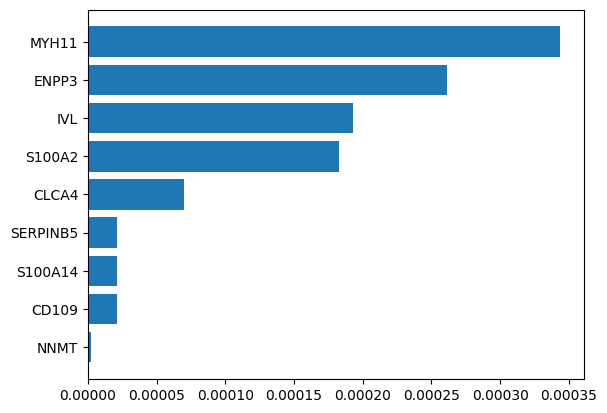

In [20]:
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names):
    imp = coef    
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = classifier
clf = svm.SVC(kernel='linear')
clf.fit(X, y)
f_importances(abs(clf.coef_[0]), features_names)

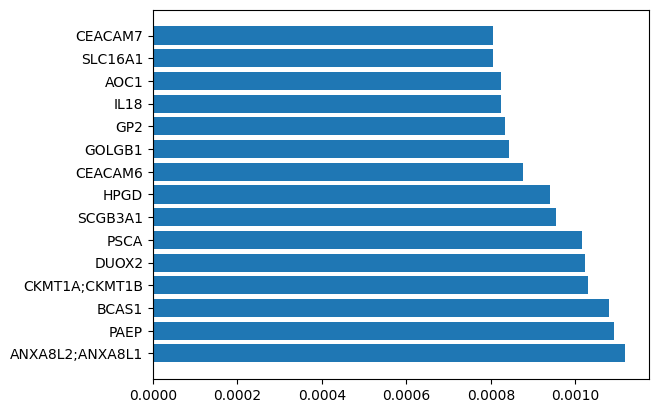

In [ ]:
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

# whatever your features are called
features_names = list(data_cols)
test = svm.SVC(kernel='linear')
test.fit(X, y)

# Specify your top n features you want to visualize.
# You can also discard the abs() function 
# if you are interested in negative contribution of features
f_importances(abs(test.coef_[0]), feature_names, top=15)